<a href="https://colab.research.google.com/github/ullasbc02/obesity-risk-analytics/blob/main/07_dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas libpysal esda


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import json
import os
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import shape, Polygon, MultiPolygon
from sklearn.neighbors import NearestNeighbors

import geopandas as gpd
import libpysal as ps
import esda
import matplotlib.pyplot as plt
from libpysal.weights import Queen
from esda.moran import Moran
from esda.getisord import G_Local

In [ ]:
# ====================================
# SECTION 1 — SETUP & DATA LOADING
# ====================================

from google.colab import drive
drive.mount('/content/drive')


DATA = "/content/drive/MyDrive/obesity-risk-analytics/dashboard_data_final/"

# Load datasets
# df_all = pd.read_csv(DATA + "df_clusters_all.csv")
# df_ses = pd.read_csv(DATA + "df_clusters_ses.csv")
# df_demo = pd.read_csv(DATA + "df_clusters_demo.csv")
# summary_all = pd.read_csv(DATA + "summary_all.csv")
# summary_ses = pd.read_csv(DATA + "summary_ses.csv")
# summary_demo = pd.read_csv(DATA + "summary_demo.csv")
# umap_embeddings = pd.read_csv(DATA + "umap_embeddings.csv")
# feature_weights = pd.read_csv(DATA + "feature_weights_all.csv", header=None)

df_dash = pd.read_csv(DATA + "dashboard_risk_data.csv", dtype={"GEOID": str})
df_dash["GEOID"] = df_dash["GEOID"].str.zfill(5)

# GEOJSON
with open(DATA + "counties_fips.geojson", "r") as f:
    counties_geojson = json.load(f)

print("Dashboard datasets loaded successfully!")


Mounted at /content/drive
Dashboard datasets loaded successfully!


# Metro


In [ ]:
DATASET = "/content/drive/MyDrive/obesity-risk-analytics/data/processed_final/"

In [ ]:
df_metro = pd.read_csv(DATASET + "data_table_metrononmetro.csv")
df_metro.head(15)

,FullGeoName,FIPS code,State,County_name,2023 Code
0,"AK, Aleutians East Borough",2013,AK,Aleutians East Borough,6 - Noncore
1,"AK, Aleutians West Ca",2016,AK,Aleutians West Census Area,6 - Noncore
2,"AK, Anchorage Muny",2020,AK,Anchorage Municipality,3 - Medium metro
3,"AK, Bethel Ca",2050,AK,Bethel Census Area,6 - Noncore
4,"AK, Bristol Bay Borough",2060,AK,Bristol Bay Borough,6 - Noncore
5,"AK, Chugach",2063,AK,Chugach Census Area,6 - Noncore
6,"AK, Copper River",2066,AK,Copper River Census Area,6 - Noncore
7,"AK, Denali Borough",2068,AK,Denali Borough,6 - Noncore
8,"AK, Dillingham Ca",2070,AK,Dillingham Census Area,6 - Noncore
9,"AK, Fairbanks North Star Borough",2090,AK,Fairbanks North Star Borough,4 - Small metro


In [ ]:
# Ensure FIPS / GEOID consistency (CRITICAL)
df_dash["GEOID"] = df_dash["GEOID"].astype(str).str.zfill(5)
df_metro["FIPS code"] = df_metro["FIPS code"].astype(str).str.zfill(5)

# Calculate centroids from geojson and add to df_all
county_centroids = {}
for feature in counties_geojson["features"]:
    geoid = feature["properties"]["GEO_ID"]
    geometry = shape(feature["geometry"])
    if isinstance(geometry, (Polygon, MultiPolygon)):
        centroid = geometry.centroid
        county_centroids[geoid] = {"latitude": centroid.y, "longitude": centroid.x}

df_centroids = pd.DataFrame.from_dict(county_centroids, orient="index")
df_centroids.index.name = "GEOID"
df_centroids.reset_index(inplace=True)

df_centroids["GEOID"] = df_centroids["GEOID"].astype(str).str.zfill(5)

df_dash = df_dash.merge(df_centroids, on="GEOID", how="left")

In [ ]:
df_all_metro = df_dash.merge(
    df_metro,
    left_on="GEOID",
    right_on="FIPS code",
    how="left"
)

In [ ]:
df_all_metro.columns


Index(['GEOID', 'CTYNAME', 'STNAME', 'obesity_rate',
       'physical_inactivity_rate', 'poverty_rate', 'low_access_food_rate',
       'median_household_income', 'unemployment_rate', 'risk_score_all',
       'risk_rank_all', 'risk_score_heal', 'risk_rank_heal', 'pct_white',
       'pct_black', 'pct_hispanic', 'pct_asian', 'pct_native', 'latitude',
       'longitude', 'FullGeoName', 'FIPS code', 'State', 'County_name',
       '2023 Code'],
      dtype='object')

In [ ]:
metro_map = {
    1: "Large central metro",
    2: "Large fringe metro",
    3: "Medium metro",
    4: "Small metro",
    5: "Micropolitan",
    6: "Noncore"
}

df_all_metro["metro_label"] = df_all_metro["2023 Code"].map(metro_map)


In [ ]:

# METRO (2023) + OBESITY AS TRANSPARENT OVERLAY FILL


# ---- BASE MAP: METRO CATEGORIES ----
base_metro = px.choropleth(
    df_all_metro,
    geojson=counties_geojson,
    locations="GEOID",
    featureidkey="id",   #  REQUIRED for your GeoJSON
    color="2023 Code",
    scope="usa",
    title="Metro vs Non-Metro Counties (2023) with Obesity Overlay"
)

base_metro.update_geos(
    showcountries=True,
    showcoastlines=True,
    showland=True,
    showlakes=False,
    resolution=110,
    showsubunits=True,
    subunitcolor="black",
    subunitwidth=0.4,
)

base_metro.update_traces(marker_line_width=0.2, marker_line_color="white")

# ---- OVERLAY: OBESITY RATE (TRANSPARENT) ----
df_obesity = df_dash.copy()

obesity_overlay = px.choropleth(
    df_obesity,
    geojson=counties_geojson,
    locations="GEOID",
    featureidkey="id",     #  REQUIRED
    color="obesity_rate",
    color_continuous_scale="Reds",
    scope="usa"
)

# Remove second color bar & borders for overlay
obesity_overlay.update_traces(
    showscale=False,
    marker_line_width=0,
    marker_opacity=0.55 # Set opacity here using marker_opacity
)

# ---- ADD OVERLAY TO BASE MAP ----
for trace in obesity_overlay.data:
    base_metro.add_trace(trace)

# ---- FINAL LAYOUT ----
base_metro.update_layout(
    height=750,
    legend=dict(
        title="Metro Category",
        orientation="h",
        yanchor="bottom",
        y=-0.12
    )
)

base_metro.show()


In [ ]:
# =============================
# METRO (2023) + OBESITY AS TRANSPARENT OVERLAY FILL
# =============================

# ---- BASE MAP: METRO CATEGORIES ----
base_metro = px.choropleth(
    df_all_metro,
    geojson=counties_geojson,
    locations="GEOID",
    featureidkey="id",   # REQUIRED for your GeoJSON
    color="2023 Code",
    scope="usa",
    title="Metro vs Non-Metro Counties (2023) with Obesity Overlay"
)

base_metro.update_geos(
    showcountries=True,
    showcoastlines=True,
    showland=True,
    showlakes=False,
    resolution=110,
    showsubunits=True,
    subunitcolor="black",
    subunitwidth=0.4,
)

base_metro.update_traces(marker_line_width=0.2, marker_line_color="white")

# ---- OVERLAY: OBESITY RATE (TRANSPARENT) ----
df_obesity = df_dash.copy()

obesity_overlay = px.choropleth(
    df_obesity,
    geojson=counties_geojson,
    locations="GEOID",
    featureidkey="id",     #  REQUIRED
    color="obesity_rate",
    color_continuous_scale="Reds",
    scope="usa"
)

# Remove second color bar & borders for overlay
obesity_overlay.update_traces(
    showscale=False,
    marker_line_width=0,
    marker_opacity=0.55 # Set opacity here using marker_opacity
)

# ---- ADD OVERLAY TO BASE MAP ----
for trace in obesity_overlay.data:
    base_metro.add_trace(trace)

# ---- FIXED TOGGLE BUTTON: SHOW / HIDE OBESITY OVERLAY ----

n_base_traces = len(px.choropleth(
    df_all_metro,
    geojson=counties_geojson,
    locations="GEOID",
    featureidkey="id",
    color="2023 Code",
    scope="usa"
).data)

n_overlay_traces = len(obesity_overlay.data)

base_visible = [True] * n_base_traces + [False] * n_overlay_traces
all_visible  = [True] * (n_base_traces + n_overlay_traces)

base_metro.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.5,
            y=1.12,
            showactive=True,
            buttons=[
                dict(
                    label="Hide Obesity Overlay",
                    method="update",
                    args=[{"visible": base_visible}],
                ),
                dict(
                    label="Show Obesity Overlay",
                    method="update",
                    args=[{"visible": all_visible}],
                ),
            ],
        )
    ]
)

# ---- FINAL LAYOUT ----
base_metro.update_layout(
    height=750,
    legend=dict(
        title="Metro Category",
        orientation="h",
        yanchor="bottom",
        y=-0.12
    )
)

base_metro.show()


# Education

In [ ]:
df_education = pd.read_csv(DATASET + "Education2023.csv", encoding='latin1')
df_education.head(50)

,FIPS Code,State,Area name,Attribute,Value
0,0,US,United States,"Less than a high school diploma, 1970",5.237331e+07
1,0,US,United States,"High school diploma only, 1970",3.415805e+07
2,0,US,United States,"Some college (1-3 years), 1970",1.165073e+07
3,0,US,United States,"Four years of college or higher, 1970",1.171727e+07
4,0,US,United States,Percent of adults with less than a high school...,4.770000e+01
5,0,US,United States,Percent of adults with a high school diploma o...,3.110000e+01
6,0,US,United States,Percent of adults completing some college (1-3...,1.060000e+01
7,0,US,United States,Percent of adults completing four years of col...,1.070000e+01
8,0,US,United States,"Less than a high school diploma, 1980",4.453520e+07
9,0,US,United States,"High school diploma only, 1980",4.594704e+07


In [ ]:
df_education["FIPS Code"] = df_education["FIPS Code"].astype(str).str.zfill(5)

df_edu_county = df_education[
    (df_education["FIPS Code"] != "00000") &
    (df_education["FIPS Code"].str.len() == 5)
].copy()


In [ ]:
edu_categories = [
    "Percent of adults who are not high school graduates, 2019-23",
    "Percent of adults who are high school graduates (or equivalent), 2019-23",
    "Percent of adults completing some college or associate degree, 2019-23",
    "Percent of adults with a bachelor's degree or higher, 2019-23"
]

df_edu_county = df_edu_county[df_edu_county["Attribute"].isin(edu_categories)]


In [ ]:
df_edu_wide = df_edu_county.pivot(
    index="FIPS Code",
    columns="Attribute",
    values="Value"
).reset_index()


In [ ]:
df_edu_wide = df_edu_wide.rename(columns={
    "FIPS Code": "GEOID",
    "Percent of adults who are not high school graduates, 2019-23": "pct_no_hs",
    "Percent of adults who are high school graduates (or equivalent), 2019-23": "pct_hs",
    "Percent of adults completing some college or associate degree, 2019-23": "pct_some_college",
    "Percent of adults with a bachelor's degree or higher, 2019-23": "pct_bachelors_plus",
})


In [ ]:
edu_cols = [
    "pct_no_hs",
    "pct_hs",
    "pct_some_college",
    "pct_bachelors_plus"
]

df_edu_wide[edu_cols] = df_edu_wide[edu_cols].apply(pd.to_numeric, errors="coerce")


In [ ]:
df_edu_wide["edu_sum_check"] = df_edu_wide[edu_cols].sum(axis=1)
df_edu_wide["edu_sum_check"].describe()


,edu_sum_check
count,3.274000e+03
mean,1.000000e+02
std,5.361811e-09
min,1.000000e+02
25%,1.000000e+02
50%,1.000000e+02
75%,1.000000e+02
max,1.000000e+02


In [ ]:
df_all_metro = df_all_metro.merge(
    df_edu_wide,
    on="GEOID",
    how="left"
)


In [ ]:
df_all_metro.head()

,GEOID,CTYNAME,STNAME,obesity_rate,physical_inactivity_rate,poverty_rate,low_access_food_rate,median_household_income,unemployment_rate,risk_score_all,...,FIPS code,State,County_name,2023 Code,metro_label,pct_some_college,pct_hs,pct_no_hs,pct_bachelors_plus,edu_sum_check
0,09001,NaN,NaN,0.222000,0.189000,0.090,0.486825,96966.0,0.035162,-4.753117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,09003,NaN,NaN,0.293000,0.209000,0.108,0.497841,75336.0,0.037397,-3.550985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,09007,NaN,NaN,0.274000,0.198000,0.070,0.600196,81721.0,0.030787,-4.577700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,09009,NaN,NaN,0.310000,0.223000,0.120,0.572042,69687.0,0.037745,-1.910094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,09011,NaN,NaN,0.307001,0.218001,0.078,0.578048,75226.0,0.034857,-2.466703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
px.choropleth(
    df_all_metro,
    geojson=counties_geojson,
    locations="GEOID",
    color="pct_bachelors_plus",
    scope="usa",
    title="Percent of Adults with a Bachelor's Degree or Higher (2019–23)"
).show()


In [ ]:

#  DOMINANT EDUCATION CATEGORY (4 CLASSES)

edu_cols = [
    "pct_no_hs",
    "pct_hs",
    "pct_some_college",
    "pct_bachelors_plus"
]

df_all_metro["dominant_education"] = df_all_metro[edu_cols].idxmax(axis=1)


/tmp/ipython-input-428262825.py:12: FutureWarning:

The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError



In [ ]:
# =============================
#  DOMINANT EDUCATION + OBESITY TOGGLE OVERLAY
# =============================

education_color_map = {
    "pct_no_hs": "#6a0dad",          # Purple
    "pct_hs": "#1f77b4",             # Blue
    "pct_some_college": "#ff7f0e",   # Orange
    "pct_bachelors_plus": "#2ca02c"  # Green
}

# ---- BASE MAP: EDUCATION ----
edu_base = px.choropleth(
    df_all_metro,
    geojson=counties_geojson,
    locations="GEOID",
    featureidkey="id",
    color="dominant_education",
    scope="usa",
    title="Dominant Education Category by County (2019–2023)",
    color_discrete_map=education_color_map
)

edu_base.update_geos(
    showcountries=True,
    showcoastlines=True,
    showland=True,
    showlakes=False,
    resolution=110,
    showsubunits=True,
    subunitcolor="black",
    subunitwidth=0.4,
)

edu_base.update_traces(marker_line_width=0.2, marker_line_color="white")

# ---- OVERLAY: OBESITY RATE (TRANSPARENT) ----
df_obesity = df_dash.copy()

edu_obesity_overlay = px.choropleth(
    df_obesity,
    geojson=counties_geojson,
    locations="GEOID",
    featureidkey="id",
    color="obesity_rate",
    color_continuous_scale="Reds",
    scope="usa"
)

edu_obesity_overlay.update_traces(
    showscale=False,
    marker_line_width=0,
    marker_opacity=0.45
)

# ---- ADD OVERLAY TO BASE MAP ----
for trace in edu_obesity_overlay.data:
    edu_base.add_trace(trace)

# ---- FIXED TOGGLE FOR EDUCATION + OBESITY ----
n_base_traces = len(px.choropleth(
    df_all_metro,
    geojson=counties_geojson,
    locations="GEOID",
    featureidkey="id",
    color="dominant_education",
    scope="usa"
).data)

n_overlay_traces = len(edu_obesity_overlay.data)

edu_base_visible = [True] * n_base_traces + [False] * n_overlay_traces
edu_all_visible  = [True] * (n_base_traces + n_overlay_traces)

edu_base.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.5,
            y=1.12,
            showactive=True,
            buttons=[
                dict(
                    label="Hide Obesity Overlay",
                    method="update",
                    args=[{"visible": edu_base_visible}],
                ),
                dict(
                    label="Show Obesity Overlay",
                    method="update",
                    args=[{"visible": edu_all_visible}],
                ),
            ],
        )
    ]
)

# ---- FINAL LAYOUT ----
edu_base.update_layout(
    height=750,
    legend_title_text="Dominant Education Category"
)

edu_base.show()


# MCDM Dashboard

In [ ]:
def plot_cluster_map(df, column, title):
    # Ensure FIPS formatted correctly
    df["GEOID"] = df["GEOID"].astype(str).str.zfill(5)

    fig = px.choropleth(
        df,
        geojson=counties_geojson,
        locations="GEOID",
        color=column,
        hover_name="CTYNAME",     # <-- County name
        hover_data={
            "STNAME": True,   # <-- State abbreviation
            "GEOID": True,        # <-- FIPS code
            "obesity_rate" : True,
            "physical_inactivity_rate" : True,
            "risk_score_all" : True
        },
        color_continuous_scale="Viridis",
        scope="usa",
        title=title,
    )

    fig.update_traces(marker_line_width=0)
    fig.update_layout(height=600)
    fig.show()


plot_cluster_map(df_dash, "obesity_rate", "Observed County-Level Obesity Rate")

In [ ]:
#Physical Inactivity
plot_cluster_map(
    df_dash,
    "physical_inactivity_rate",
    "County-Level Physical Inactivity Rate"
)


In [ ]:
#Risk Score
plot_cluster_map(
    df_dash,
    "risk_score_all",
    "Predicted Obesity Risk Priority (Composite Risk Score)"
)


In [ ]:
#Poverty Score
plot_cluster_map(
    df_dash,
    "poverty_rate",
    "County-Level Poverty Rate"
)


In [ ]:
#Health Rank score
plot_cluster_map(
    df_dash,
    "risk_score_heal",
    "Predicted Obesity Risk Priority (Composite Risk Score)"
)


In [ ]:
#Health Rank score
plot_cluster_map(
    df_dash,
    "risk_score_heal",
    "Predicted Obesity Risk Priority (Composite Risk Score)"
)


# Residue Plot

In [ ]:
predicted_data = "/content/drive/MyDrive/obesity-risk-analytics/data/processed_final/"

df_pred = pd.read_csv(predicted_data + "df_final_with_predictions.csv", dtype={"GEOID": str})
df_pred["GEOID"] = df_pred["GEOID"].str.zfill(5)

In [ ]:
#Residual Map
plot_cluster_map(
    df_pred,
    "residual",
    "Residual Map"
)


# Spatial Hotspots

In [ ]:

# STEP 1 — BUILD SPATIAL GDF


# Convert geojson → GeoDataFrame
gdf_counties = gpd.GeoDataFrame.from_features(counties_geojson["features"])

# Inspect available columns (run once visually)
print("GeoJSON Columns:", gdf_counties.columns)

# Your GEOID comes from GEO_ID inside properties
gdf_counties["GEOID"] = (
    gdf_counties["GEO_ID"]
    .astype(str)
    .str.replace("0500000US", "", regex=False)
    .str.zfill(5)
)

# Ensure df_dash GEOID is formatted correctly
df_dash["GEOID"] = df_dash["GEOID"].astype(str).str.zfill(5)

#  Merge geometry + obesity data
gdf = gdf_counties.merge(df_dash, on="GEOID", how="inner")

print("Final Spatial Rows:", len(gdf))  # MUST be > 3000
gdf.head()


GeoJSON Columns: Index(['geometry', 'GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA'], dtype='object')
Final Spatial Rows: 3119


,geometry,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,GEOID,CTYNAME,STNAME,...,risk_rank_all,risk_score_heal,risk_rank_heal,pct_white,pct_black,pct_hispanic,pct_asian,pct_native,latitude,longitude
0,"POLYGON ((-86.49677 32.34444, -86.7179 32.4028...",0500000US01001,01,001,Autauga,County,594.436,01001,Autauga County,Alabama,...,625.0,1.491197,575.0,0.758639,0.204898,0.035867,0.011735,0.004847,NaN,NaN
1,"POLYGON ((-86.5778 33.76532, -86.75914 33.8406...",0500000US01009,01,009,Blount,County,644.776,01009,Blount County,Alabama,...,1139.0,0.571701,1060.0,0.957145,0.017216,0.097531,0.003754,0.006477,NaN,NaN
2,"POLYGON ((-85.18413 32.87052, -85.12342 32.772...",0500000US01017,01,017,Chambers,County,596.531,01017,Chambers County,Alabama,...,1660.0,-0.053869,1485.0,0.569555,0.402542,0.035022,0.011472,0.003632,NaN,NaN
3,"POLYGON ((-86.51734 33.02057, -86.51596 32.929...",0500000US01021,01,021,Chilton,County,692.854,01021,Chilton County,Alabama,...,581.0,1.616749,524.0,0.869946,0.103284,0.097263,0.004710,0.006398,NaN,NaN
4,"POLYGON ((-88.13999 34.5817, -88.13925 34.5878...",0500000US01033,01,033,Colbert,County,592.619,01033,Colbert County,Alabama,...,414.0,2.216657,323.0,0.803222,0.162566,0.030525,0.006744,0.006657,NaN,NaN


In [ ]:

# STEP 2 — QUEEN CONTIGUITY

w = Queen.from_dataframe(gdf)
w.transform = "r"

print("Total Counties:", w.n)
print("Mean Neighbors:", np.mean(list(w.cardinalities.values())))


/tmp/ipython-input-4280506154.py:7: FutureWarning:

`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning



('WARNING: ', 822, ' is an island (no neighbors)')
('WARNING: ', 823, ' is an island (no neighbors)')
('WARNING: ', 2355, ' is an island (no neighbors)')
('WARNING: ', 2798, ' is an island (no neighbors)')
('WARNING: ', 2846, ' is an island (no neighbors)')
('WARNING: ', 2902, ' is an island (no neighbors)')
('WARNING: ', 3004, ' is an island (no neighbors)')
Total Counties: 3119
Mean Neighbors: 5.804424495030458


/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning:

The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 7 islands with ids: 822, 823, 2355, 2798, 2846, 2902, 3004.



In [ ]:

# STEP 3 — GLOBAL MORAN'S I


from esda.moran import Moran

y = gdf["obesity_rate"].values
mi = Moran(y, w)

print("Global Moran's I:", round(mi.I, 4))
print("p-value:", round(mi.p_sim, 6))


Global Moran's I: 0.3396
p-value: 0.001


In [ ]:

# STEP 4 — GETIS-ORD Gi*


from esda.getisord import G_Local

gi = G_Local(y, w)
gdf["gi_zscore"] = gi.Zs


/usr/local/lib/python3.12/dist-packages/esda/getisord.py:527: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.12/dist-packages/esda/getisord.py:450: RuntimeWarning:

invalid value encountered in divide



In [ ]:

# STEP 5 — HOTSPOT CLASSIFICATION


def classify_hotspot(z):
    if z > 1.65:
        return "Very Hot Spot (90%)"
    elif z > 1.28:
        return "Hot Spot (80%)"
    elif z < -1.65:
        return "Very Cold Spot (90%)"
    elif z < -1.28:
        return "Cold Spot (80%)"
    else:
        return "Not Significant"

gdf["hotspot_class"] = gdf["gi_zscore"].apply(classify_hotspot)

gdf["hotspot_class"].value_counts()


,count
hotspot_class,
Not Significant,2968
Cold Spot (80%),66
Hot Spot (80%),63
Very Hot Spot (90%),19
Very Cold Spot (90%),3


In [ ]:
#Quantile Based
# gdf["hotspot_class"] = pd.qcut(
#     gdf["gi_zscore"],
#     q=[0, 0.15, 0.85, 1.0],
#     labels=["Cold Priority Zone", "Normal", "Hot Priority Zone"]
# )

# gdf["hotspot_class"].value_counts()


,count
hotspot_class,
Normal,2178
Cold Priority Zone,467
Hot Priority Zone,467


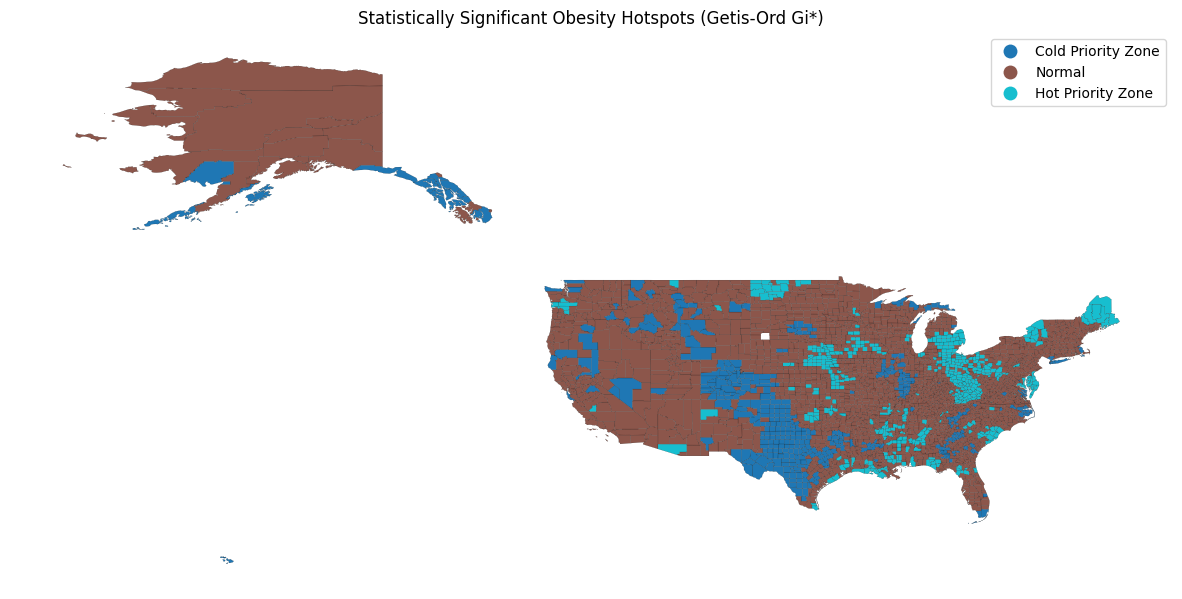

In [ ]:

# STEP 6 — HOTSPOT MAP


fig, ax = plt.subplots(1, 1, figsize=(15, 9))

gdf.plot(
    column="hotspot_class",
    categorical=True,
    legend=True,
    edgecolor="black",
    linewidth=0.1,
    ax=ax
)

ax.set_title("Statistically Significant Obesity Hotspots (Getis-Ord Gi*)")
ax.axis("off")
plt.show()


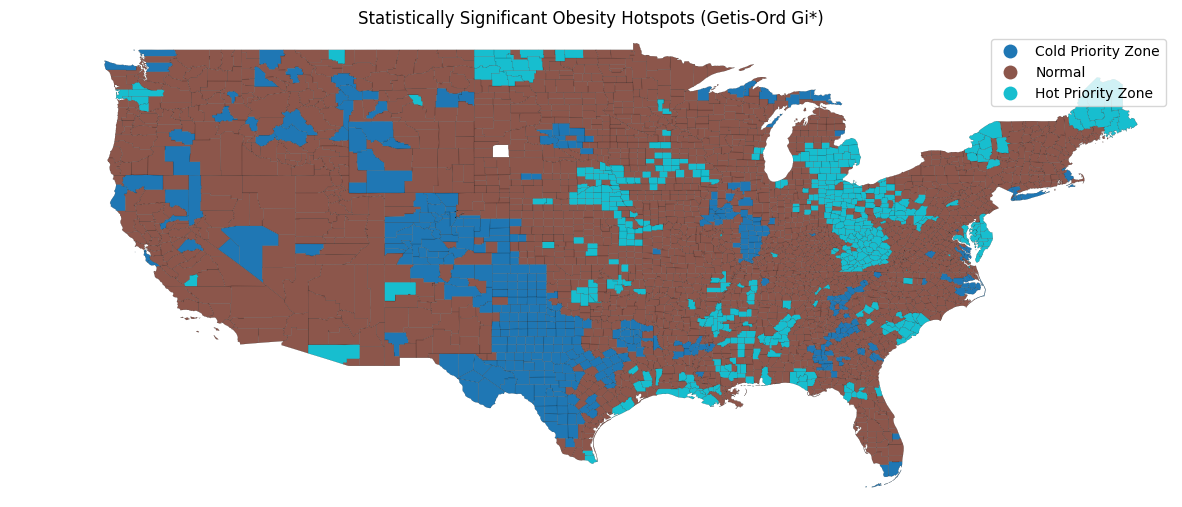

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

gdf.plot(
    column="hotspot_class",
    categorical=True,
    legend=True,
    edgecolor="black",
    linewidth=0.1,
    ax=ax
)

# ZOOM TO CONTINENTAL USA
ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])

ax.set_title("Statistically Significant Obesity Hotspots (Getis-Ord Gi*)")
ax.axis("off")
plt.show()


In [ ]:
df_dash

,GEOID,CTYNAME,STNAME,obesity_rate,physical_inactivity_rate,poverty_rate,low_access_food_rate,median_household_income,unemployment_rate,risk_score_all,risk_rank_all,risk_score_heal,risk_rank_heal,pct_white,pct_black,pct_hispanic,pct_asian,pct_native,latitude,longitude
0,09001,NaN,NaN,0.222000,0.189000,0.090000,0.486825,96966.0,0.035162,-4.753117,2676.0,-2.128926,2883.0,0.845836,0.033922,0.045702,0.007092,0.008037,NaN,NaN
1,09003,NaN,NaN,0.293000,0.209000,0.108000,0.497841,75336.0,0.037397,-3.550985,2390.0,-1.300148,2433.0,0.845836,0.033922,0.045702,0.007092,0.008037,NaN,NaN
2,09007,NaN,NaN,0.274000,0.198000,0.070000,0.600196,81721.0,0.030787,-4.577700,2639.0,-1.625113,2643.0,0.845836,0.033922,0.045702,0.007092,0.008037,NaN,NaN
3,09009,NaN,NaN,0.310000,0.223000,0.120000,0.572042,69687.0,0.037745,-1.910094,1932.0,-0.639752,1931.0,0.845836,0.033922,0.045702,0.007092,0.008037,NaN,NaN
4,09011,NaN,NaN,0.307001,0.218001,0.078000,0.578048,75226.0,0.034857,-2.466703,2072.0,-0.836346,2094.0,0.845836,0.033922,0.045702,0.007092,0.008037,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,56037,Sweetwater County,Wyoming,0.340004,0.217006,0.083001,0.339748,80639.0,0.039985,-2.109221,1978.0,-1.164534,2336.0,0.939437,0.013177,0.164135,0.009723,0.014502,NaN,NaN
3117,56039,Teton County,Wyoming,0.154001,0.122003,0.060002,0.322673,98837.0,0.028209,-13.012932,3117.0,-5.058778,3118.0,0.948986,0.007845,0.141638,0.015218,0.009817,NaN,NaN
3118,56041,Uinta County,Wyoming,0.283016,0.247014,0.085001,0.000000,70756.0,0.039644,-0.446029,1510.0,-0.351045,1707.0,0.954910,0.006406,0.096929,0.004793,0.015209,NaN,NaN
3119,56043,Washakie County,Wyoming,0.246022,0.215032,0.111009,0.389781,55122.0,0.041312,-3.825525,2459.0,-1.184647,2357.0,0.948731,0.004945,0.140924,0.008198,0.016786,NaN,NaN


# Casual Modeling

In [ ]:
import statsmodels.api as sm

# Define variables
y = df_dash["obesity_rate"]

X = df_dash[
    [
        "median_household_income", # TREATMENT
        "physical_inactivity_rate", # CONTROL
        "poverty_rate",               # CONTROL
        "pct_black",                  # CONTROL
        "pct_hispanic"                # CONTROL
    ]
]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           obesity_rate   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     351.1
Date:                Mon, 01 Dec 2025   Prob (F-statistic):          4.59e-299
Time:                        21:42:49   Log-Likelihood:                 5715.2
No. Observations:                3121   AIC:                        -1.142e+04
Df Residuals:                    3115   BIC:                        -1.138e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   